In [1]:
import glob
import imageio
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max, blob_log, blob_dog

from deepcell_spots.spot_em import load_coords, cluster_coords, predict_cluster_probabilities

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [2]:
files = glob.glob('../data/example_images/MERFISH_cropped.tiff')

In [3]:
im = imageio.volread(files[0])
np.shape(im)

(75, 75)

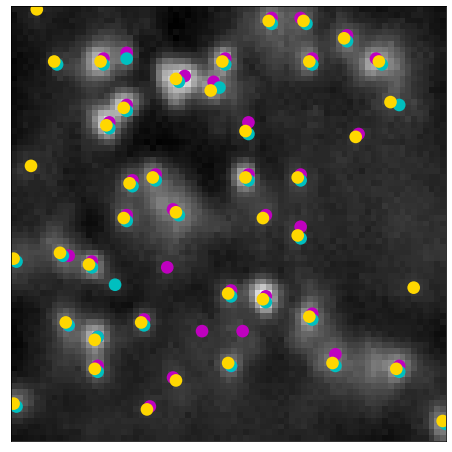

In [4]:
coords_plm = peak_local_max(im, threshold_rel=0.05, min_distance=2)
coords_log = blob_log(im, max_sigma=2, threshold_rel=0.1)
coords_dog = blob_dog(im, max_sigma=2, threshold_rel=0.08)

plt.figure(figsize=(8,8))

s = 160
lw = 0.5
j=0.5
edge_c='None'

plt.imshow(im, cmap='gray')
plt.scatter(coords_plm[:,1]+j, coords_plm[:,0]-j, s=s, c='m', label='PLM', edgecolors=edge_c, linewidth=lw)
plt.scatter(coords_log[:,1]+j, coords_log[:,0]+j, s=s, c='c', label='LoG', edgecolors=edge_c, linewidth=lw)
plt.scatter(coords_dog[:,1], coords_dog[:,0], s=s, c='gold', label='DoG', edgecolors=edge_c, linewidth=lw)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
coords_dict = {
    'PLM': [coords_plm],
    'LoG': [coords_log],
    'DoG': [coords_dog]
}

coords_df = load_coords(coords_dict)
coords_df = cluster_coords(coords_df, threshold=1.5)
coords_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


,Algorithm,Image,x,y,Cluster
0,PLM,0,43,50,0.0
1,LoG,0,43.0,50.0,0.0
2,DoG,0,43.0,50.0,0.0
3,PLM,0,29,12,1.0
4,LoG,0,28.0,12.0,1.0


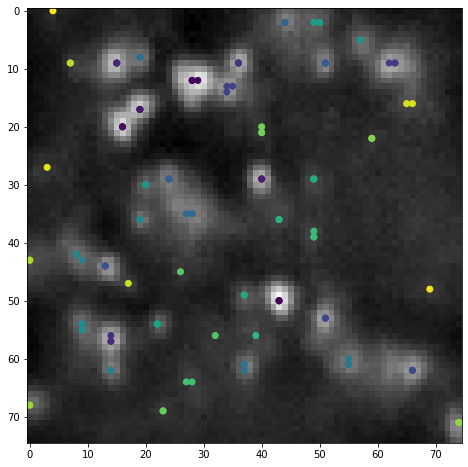

In [6]:
# not shown in Figure 1b
plt.figure(figsize=(8,8))
plt.imshow(im, cmap='gray')
plt.scatter(coords_df['x'], coords_df['y'], c=coords_df['Cluster'])
plt.show()

In [7]:
tpr_dict = {'LoG': 0.9, 'DoG': 0.9, 'PLM': 0.9}
fpr_dict = {'LoG': 0.1, 'DoG': 0.1, 'PLM': 0.1}
coords_df = predict_cluster_probabilities(coords_df, tpr_dict, fpr_dict)
coords_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2094.95it/s]


,Algorithm,Image,x,y,Cluster,Probability,Centroid_x,Centroid_y
0,PLM,0,43,50,0,0.994646,43.000000,50.0
1,LoG,0,43.0,50.0,0,0.994646,43.000000,50.0
2,DoG,0,43.0,50.0,0,0.994646,43.000000,50.0
3,PLM,0,29,12,1,0.994646,28.333333,12.0
4,LoG,0,28.0,12.0,1,0.994646,28.333333,12.0


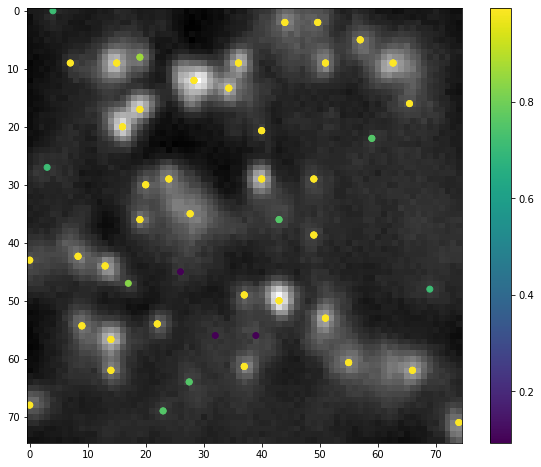

In [8]:
# not shown in Figure 1b
plt.figure(figsize=(10,8))
plt.imshow(im, cmap='gray')
plt.scatter(coords_df['Centroid_x'], coords_df['Centroid_y'], c=coords_df['Probability'])
plt.colorbar()
plt.show()

In [9]:
consensus_df = coords_df[['Image', 'Centroid_x', 'Centroid_y', 'Probability']].copy()
consensus_df = consensus_df.drop_duplicates()
consensus_df = consensus_df.drop(consensus_df.loc[consensus_df.Probability < 0.9].index)
consensus_df = consensus_df.drop(consensus_df.loc[consensus_df.Centroid_x > 127].index)
consensus_df = consensus_df.drop(consensus_df.loc[consensus_df.Centroid_y > 127].index)
consensus_df = consensus_df.drop(consensus_df.loc[consensus_df.Centroid_x < 0].index)
consensus_df = consensus_df.drop(consensus_df.loc[consensus_df.Centroid_y < 0].index)
consensus_df.head()

,Image,Centroid_x,Centroid_y,Probability
0,0,43.000000,50.0,0.994646
3,0,28.333333,12.0,0.994646
6,0,16.000000,20.0,0.994646
9,0,19.000000,17.0,0.994646
12,0,40.000000,29.0,0.994646


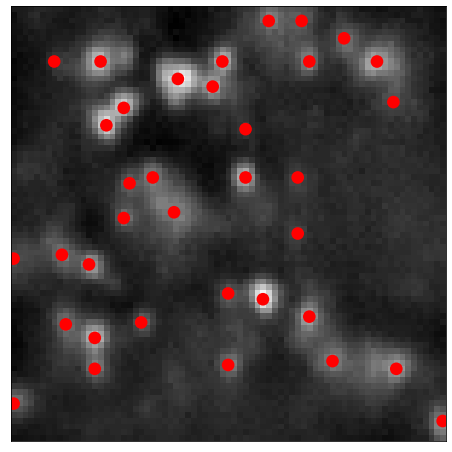

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(im, cmap='gray')
plt.scatter(consensus_df['Centroid_x'], consensus_df['Centroid_y'], s=s, c='r', edgecolors=edge_c, linewidth=lw)
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
# Function from ImageFullyConvDotIterator implemented in deepcell_spots.image_generators
from deepcell_spots.utils import (affine_transform_points,
                                  subpixel_distance_transform)
from tensorflow.keras.utils import to_categorical

def point_list_to_annotations(points, image_shape, dy=1, dx=1):
    """ Generate label images used in loss calculation from point labels.
    Args:
        points (np.array): array of size (N, 2) which contains points in the format [y, x].
        image_shape (tuple): shape of 2-dimensional image.
        dy: pixel y width.
        dx: pixel 
        x width.
    Returns:
        annotations (dict): Dictionary with two keys, `detections` and `offset`.
            - `detections` is array of shape (image_shape,2) with pixels one hot encoding
              spot locations.
            - `offset` is array of shape (image_shape,2) with pixel values equal to
              signed distance to nearest spot in x- and y-directions.
    """

    contains_point = np.zeros(image_shape)
    for ind, [y, x] in enumerate(points):
        nearest_pixel_x_ind = int(round(x / dx))
        nearest_pixel_y_ind = int(round(y / dy))
        contains_point[nearest_pixel_y_ind, nearest_pixel_x_ind] = 1

    delta_y, delta_x, _ = subpixel_distance_transform(
        points, image_shape, dy=1, dx=1)
    offset = np.stack((delta_y, delta_x), axis=-1)

    one_hot_encoded_cp = to_categorical(contains_point)

    annotations = {'detections': one_hot_encoded_cp, 'offset': offset}
    return annotations

In [12]:
annotations = point_list_to_annotations(np.array([consensus_df['Centroid_y'], consensus_df['Centroid_x']]).T, (75,75))

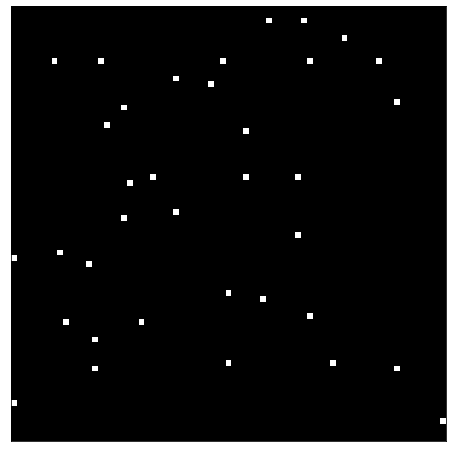

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(annotations['detections'][...,1], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

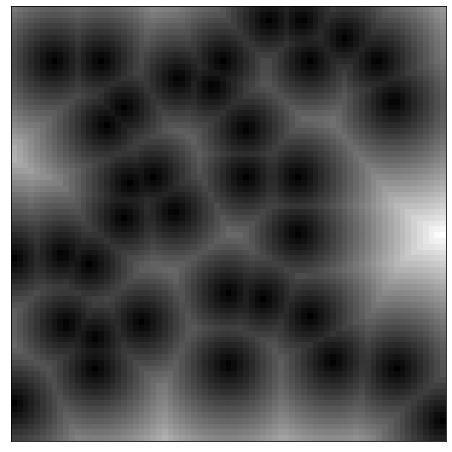

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(np.sqrt(annotations['offset'][...,0]**2 + annotations['offset'][...,1]**2), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()